# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Load-the-final-text-cleancat15-data" data-toc-modified-id="Load-the-final-text-cleancat15-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the final text cleancat15 data</a></div><div class="lev1 toc-item"><a href="#Plot-magnidude-for-different-bin-numbers" data-toc-modified-id="Plot-magnidude-for-different-bin-numbers-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot magnidude for different bin numbers</a></div><div class="lev1 toc-item"><a href="#Magnitude-weight-column-for-Monochromatic-case" data-toc-modified-id="Magnitude-weight-column-for-Monochromatic-case-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Magnitude weight column for Monochromatic case</a></div><div class="lev1 toc-item"><a href="#Magnitude-weight-column-for-Chromatic-case" data-toc-modified-id="Magnitude-weight-column-for-Chromatic-case-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Magnitude weight column for Chromatic case</a></div><div class="lev1 toc-item"><a href="#Ellipticity-Components-Transformation" data-toc-modified-id="Ellipticity-Components-Transformation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Ellipticity Components Transformation</a></div><div class="lev1 toc-item"><a href="#Radial-Bins-groupings" data-toc-modified-id="Radial-Bins-groupings-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Radial Bins groupings</a></div><div class="lev1 toc-item"><a href="#gm-vs-gc-Plots" data-toc-modified-id="gm-vs-gc-Plots-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>gm vs gc Plots</a></div>

# Introduction
Date: Dec 9, 2019 Mon

**Purpose**  
1. Find the weights for g_sq for given magnitude bins using smooth fitting curve.



**Usual Filtering**  
```python
df = df.query('calib_psfCandidate == 0.0')
df = df.query('deblend_nChild == 0.0')
df['ellip'] = np.hypot( df['ext_shapeHSM_HsmShapeRegauss_e1'] ,
                        df['ext_shapeHSM_HsmShapeRegauss_e2'] )
df = df.query('ellip < 2.0') # it was 1.5 before

#select only few columns after filtering:
cols_select = ['base_SdssCentroid_x', 'base_SdssCentroid_y',
                'base_SdssCentroid_xSigma','base_SdssCentroid_ySigma',
                'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2',
                'base_SdssShape_flux']
df = df[cols_select]        

# drop all nans
df = df.dropna()

# additional columns
df['radius'] =  df.eval(""" ( (ext_shapeHSM_HsmSourceMoments_xx *  ext_shapeHSM_HsmSourceMoments_yy) \
                                          -  (ext_shapeHSM_HsmSourceMoments_xy**2 ) )**0.25 """)
```

**Shape filtering**  
https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_2_lensing_cuts.ipynb
```python
df = df.query('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3')
df = df.query('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')
df = df.query('ext_shapeHSM_HsmShapeRegauss_flag== 0.0')
```

**Filter strongly lensed objects**  
- Take the objects with centroids >154 pixels (remove strong lens objects).
```python
# exclude strong lens objects <=154 distance
# The shape of lsst.fits file is 3998,3998 and center is 1699,1699.
df['x_center'] = 1699
df['y_center'] = 1699
df['distance'] = ( (df['x[0]'] - df['x_center'])**2 + (df['x[1]'] - df['y_center'])**2 )**0.5
df = df[df.distance > 154]
```

**Imcat script**  
```bash

# create new columns and cleaning (four files)
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${M9T}".txt  |  lc +all 'mag = %flux log10 -2.5 *'  |  cleancat 15  |  lc +all -r 'mag' > "${M9C}".cat


# merge 4 catalogs
mergecats 5 "${MC}".cat "${M9C}".cat "${LC}".cat "${L9C}".cat > ${catalogs}/merge.cat &&
            
            
lc -b +all 
'x = %x[0][0] %x[1][0] + %x[2][0] + %x[3][0] + 4 / %x[0][1] %x[1][1] + %x[2][1] + %x[3][1] + 4 / 2 vector'
'gm = %g[0][0] %g[1][0] + 2 / %g[0][1] %g[1][1] + 2 / 2 vector' 
'gc = %g[2][0] %g[3][0] + 2 / %g[2][1] %g[3][1] + 2 / 2 vector'   
'gmd = %g[0][0] %g[1][0] - 2 / %g[0][1] %g[1][1] - 2 / 2 vector' 
'gcd = %g[2][0] %g[3][0] - 2 / %g[2][1] %g[3][1] - 2 / 2 vector' 
< ${catalogs}/merge.cat > ${final}/final_${i}.cat
```
**Notes**  

final_text.txt is created by imcat program after merging four lsst files (m,m9,l,l9) after cleaning.

# Imports

In [1]:
import json, os,sys
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Load the final text cleancat15 data

```
g_sq = g00 g00 + g10 g10
gmd_sq = gmd0**2 + gmd1**2

```

In [3]:
!head -2 ../data/cleancat/final_text_cleancat15.txt

#       fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]
               0              0              0              0           5301           5314           5231           5117       88.17075      1847.1934         0.0196         0.0249         0.0227         0.0216           0.02         0.0256       

In [4]:
names = "fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]"
print(names)

fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]


In [5]:
names = ['fN[0][0]','fN[1][0]','fN[2][0]','fN[3][0]',
 'id[0][0]','id[1][0]','id[2][0]','id[3][0]',
 'x[0]','x[1]',
 'errx[0][0]','errx[0][1]','errx[1][0]','errx[1][1]','errx[2][0]',
 'errx[2][1]','errx[3][0]','errx[3][1]',
 'g[0][0]','g[0][1]','g[1][0]','g[1][1]','g[2][0]','g[2][1]','g[3][0]','g[3][1]',
 'ellip[0][0]','ellip[1][0]','ellip[2][0]','ellip[3][0]',
 'flux[0][0]','flux[1][0]','flux[2][0]','flux[3][0]',
 'radius[0][0]','radius[1][0]','radius[2][0]','radius[3][0]',
 'mag[0][0]','mag[1][0]','mag[2][0]','mag[3][0]',
 'gm[0]','gm[1]','gc[0]', 'gc[1]',
 'gmd[0]','gmd[1]','gcd[0]','gcd[1]']


file_path = f'../data/cleancat/final_text_cleancat15.txt'


df = pd.read_csv(file_path,comment='#',engine='python',sep=r'\s\s+',
                 header=None,names=names)

print(df.shape)

# new columns
# df['g_sq'] = df['g[0][0]'] **2 + df['g[1][0]']**2 # only for imcat 00 and 10
# df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

df['g_sq'] = df['g[0][0]'] **2 + df['g[0][1]']**2
df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2

df['mag_mono'] = (df['mag[0][0]'] + df['mag[1][0]'] ) / 2
df['mag_chro'] = (df['mag[2][0]'] + df['mag[3][0]'] ) / 2


df.head()

(56861, 50)


,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],mag[0][0],mag[1][0],mag[2][0],mag[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],g_sq,gmd_sq,gm_sq,gc_sq,mag_mono,mag_chro
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.466340,0.420373,79841.4700,82737.3540,80303.9230,83923.9080,5.186953,5.293858,5.267827,5.390682,-12.255571,-12.294254,-12.261842,-12.309714,-0.07615,-0.05830,-0.07395,-0.06255,-0.34915,0.24380,-0.35175,0.25295,0.215290,0.181344,0.009198,0.009381,-12.274912,-12.285778
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.974240,0.865835,33913.5470,34112.9040,33903.5430,34114.7980,4.676457,4.750963,4.675408,4.751770,-11.325933,-11.332297,-11.325613,-11.332357,0.84675,0.33110,0.85675,0.33405,0.06005,-0.00800,0.06115,-0.00755,0.926680,0.003670,0.826613,0.845610,-11.329115,-11.328985
2,0,0,0,0,1301,1310,1323,1312,2652.56650,1772.34480,0.2510,0.1715,0.1663,0.3002,0.2522,0.1715,0.1665,0.3017,0.9614,0.5881,-0.9979,-0.4635,1.0062,0.6076,-1.0206,-0.4729,1.127010,1.100289,1.175422,1.124837,3694.2411,3674.4453,3684.1640,3663.4596,4.161950,4.303319,4.159870,4.301257,-8.918813,-8.912980,-8.915847,-8.909728,-0.01825,0.06230,-0.00720,0.06735,0.97965,0.52580,1.01340,0.54025,1.270152,1.236180,0.004214,0.004588,-8.915896,-8.912788
3,0,0,0,0,3564,3564,3541,3538,2536.84490,712.48793,0.0071,0.0125,0.0071,0.0129,0.0074,0.0129,0.0074,0.0134,-1.0289,0.4499,-1.0196,0.3961,-0.9862,0.4332,-0.9816,0.3755,1.122963,1.093837,1.077150,1.050970,107866.5700,109330.9900,109214.9900,110405.2400,4.848973,4.967938,4.963241,5.096215,-12.582217,-12.596858,-12.595706,-12.607474,-1.02425,0.42300,-0.98390,0.40435,-0.00465,0.02690,-0.00230,0.02885,1.261045,0.000745,1.228017,1.131558,-12.589538,-12.601590
4,0,0,0,0,4634,4659,4569,4615,109.82575,1405.32120,0.3760,0.3919,0.2353,0.2783,0.3803,0.3949,0.2379,0.2831,0.2055,0.1655,-0.1817,-0.0868,0.2052,0.1698,-0.1773,-0.0987,0.263857,0.201368,0.266344,0.202921,3512.8911,3518.9333,3517.0462,3518.1529,4.338535,4.362407,4.374177,4.392268,-8.864162,-8.866028,-8.865445,-8.865787,0.01190,0.03935,0.01395,0.03555,0.19360,0.12615,0.19125,0.13425,0.069621,0.053395,0.001690,0.001458,-8.865095,-8.865616


# Plot magnidude for different bin numbers

In [6]:
df.filter(regex='mag').head(2)

,mag[0][0],mag[1][0],mag[2][0],mag[3][0],mag_mono,mag_chro
0,-12.255571,-12.294254,-12.261842,-12.309714,-12.274912,-12.285778
1,-11.325933,-11.332297,-11.325613,-11.332357,-11.329115,-11.328985


In [7]:
def plot_bin_mag_mono_chro(nbins,show=False):
    import os
    
    if not os.path.isdir('images'):
        os.makedirs('images')
    
    df['bins_mag_mono'] = pd.cut(df['mag_mono'],nbins)
    df['bins_mag_chro'] = pd.cut(df['mag_chro'],nbins)
    
    text_mono = df.groupby('bins_mag_mono')['gm_sq'].count().to_string()
    text_chro = df.groupby('bins_mag_chro')['gc_sq'].count().to_string()

    # plot
    fig,ax = plt.subplots(1,2,figsize=(12,8))
    
    # mono
    df.groupby('bins_mag_mono')['gm_sq'].mean().plot(marker='o',ax=ax[0])
    ax[0].tick_params(axis='x', rotation=90)
    ax[0].set_ylabel('gm_sq_mean',fontsize=18)
    ax[0].set_xlabel('bin_mag_mono',fontsize=18)
    ax[0].set_title(f'gm_sq per magnitude bins with nbins = {nbins}')
    ax[0].text(0,0.5,text_mono,fontsize=14,va='center')
    ax[0].set_ylim(0,1)
    ax[0].set_yticks(np.arange(0, 1, step=0.1))
    
    # chro
    df.groupby('bins_mag_chro')['gc_sq'].mean().plot(marker='o',ax=ax[1])
    ax[1].tick_params(axis='x', rotation=90)
    ax[1].set_ylabel('gc_sq_mean',fontsize=18)
    ax[1].set_xlabel('bin_mag_chro',fontsize=18)
    ax[1].set_title(f'gc_sq per magnitude bins with nbins = {nbins}')
    ax[1].text(0,0.5,text_chro,fontsize=14,va='center')
    ax[1].set_ylim(0,1)
    ax[1].set_yticks(np.arange(0, 1, step=0.1))
    
    plt.savefig(f'images/bin_mag_mono_chro_{nbins}.png')
    
    plt.tight_layout()

    if show:
        plt.show()
    plt.close()

for nbins in range(5,15):
    plot_bin_mag_mono_chro(nbins)

![](images/bin_mag_mono_chro_5.png)
![](images/bin_mag_mono_chro_6.png)
![](images/bin_mag_mono_chro_7.png)
![](images/bin_mag_mono_chro_8.png)
![](images/bin_mag_mono_chro_9.png)
![](images/bin_mag_mono_chro_10.png)
![](images/bin_mag_mono_chro_11.png)
![](images/bin_mag_mono_chro_12.png)
![](images/bin_mag_mono_chro_13.png)
![](images/bin_mag_mono_chro_14.png)

# Magnitude weight column for Monochromatic case

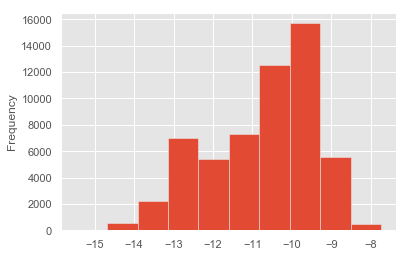

In [8]:
df['mag_mono'].plot.hist()

In [9]:
from scipy.optimize import curve_fit

# look at case when nbins = 9 and when the curve is going up
mag_low_nbins9 = (-12.884-12.028) / 2
mag_high_nbins9 = (-10.314-9.457) / 2

xcol = 'mag_mono'
ycol = 'gm_sq'

x = df.query("""  @mag_low_nbins9 < mag_mono <  @mag_high_nbins9  """)[xcol].to_numpy()
y = df.query("""  @mag_low_nbins9 < mag_mono <  @mag_high_nbins9  """)[ycol].to_numpy()

def func(x, a, b):
    return a*x + b

params, _ = curve_fit(func, x, y)
[a, b] = params.round(2)

print(f'magnitude ranges for mono: {mag_low_nbins9}, {mag_high_nbins9}')
print(f'fitting params   for mono: {a}, {b}' )

magnitude ranges for mono: -12.456, -9.8855
fitting params   for mono: 0.24, 3.1


In [10]:
def magnitude_weight_mono(mag):
    if mag < -12.456:
        return 1/ 0.1
    
    else:
        return 1/ (a*mag + b)

df['wt_mag_mono'] = df['mag_mono'].apply(magnitude_weight_mono)
df['wt_mag_mono'] = df['wt_mag_mono'] / df['wt_mag_mono'].mean() # normalize by mean

# Magnitude weight column for Chromatic case

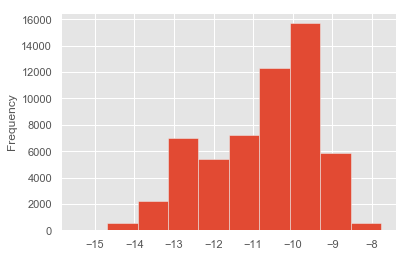

In [11]:
df['mag_chro'].plot.hist()

In [12]:
from scipy.optimize import curve_fit

# look at case when nbins = 9 and when the curve is going up
mag_low_nbins9 = (-12.895-12.041) / 2
mag_high_nbins9 = (-10.333-9.479) / 2

xcol = 'mag_chro'
ycol = 'gc_sq'

x = df.query("""  @mag_low_nbins9 < mag_chro <  @mag_high_nbins9  """)[xcol].to_numpy()
y = df.query("""  @mag_low_nbins9 < mag_chro <  @mag_high_nbins9  """)[ycol].to_numpy()

def func(x, a, b):
    return a*x + b

params, _ = curve_fit(func, x, y)
[a, b] = params.round(2)

print(f'magnitude ranges for chro: {mag_low_nbins9}, {mag_high_nbins9}')
print(f'fitting params   for chro: {a}, {b}' )

magnitude ranges for chro: -12.468, -9.905999999999999
fitting params   for chro: 0.25, 3.13


In [13]:
def magnitude_weight_chro(mag):
    if mag < -12.468:
        return 1/ 0.1
    
    else:
        return 1/ (a*mag + b)

df['wt_mag_chro'] = df['mag_chro'].apply(magnitude_weight_chro)
df['wt_mag_chro'] = df['wt_mag_chro'] / df['wt_mag_chro'].mean() # normalize by mean

# mean
df['wt_mag']      = (df['wt_mag_mono'] + df['wt_mag_chro']) / 2

# df.drop(['wt_mag_chro','wt_mag_mono'],axis=1,inplace=True)

df.iloc[:2,-7:]

,mag_mono,mag_chro,bins_mag_mono,bins_mag_chro,wt_mag_mono,wt_mag_chro,wt_mag
0,-12.274912,-12.285778,"(-12.701, -12.15]","(-12.712, -12.163]",1.950789,3.647449,2.799119
1,-11.329115,-11.328985,"(-11.599, -11.048]","(-11.614, -11.065]",0.788590,0.717298,0.752944


# Ellipticity Components Transformation
```perl
c2 = (dx * dx - dy * dy) / (r * r);
s2 = 2 * dx * dy / (r * r);
eX = s2 * e[0] + c2 * e[1];
eesum += eX * eX * w[0] * w[0];
eTsum[bin] -= (c2 * e[0] + s2 * e[1]) * w[0];
```

In [14]:
df.head(2)

,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],mag[0][0],mag[1][0],mag[2][0],mag[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],g_sq,gmd_sq,gm_sq,gc_sq,mag_mono,mag_chro,bins_mag_mono,bins_mag_chro,wt_mag_mono,wt_mag_chro,wt_mag
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.46634,0.420373,79841.470,82737.354,80303.923,83923.908,5.186953,5.293858,5.267827,5.390682,-12.255571,-12.294254,-12.261842,-12.309714,-0.07615,-0.0583,-0.07395,-0.06255,-0.34915,0.2438,-0.35175,0.25295,0.21529,0.181344,0.009198,0.009381,-12.274912,-12.285778,"(-12.701, -12.15]","(-12.712, -12.163]",1.950789,3.647449,2.799119
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.97424,0.865835,33913.547,34112.904,33903.543,34114.798,4.676457,4.750963,4.675408,4.751770,-11.325933,-11.332297,-11.325613,-11.332357,0.84675,0.3311,0.85675,0.33405,0.06005,-0.0080,0.06115,-0.00755,0.92668,0.003670,0.826613,0.845610,-11.329115,-11.328985,"(-11.599, -11.048]","(-11.614, -11.065]",0.788590,0.717298,0.752944


In [15]:
# constants
RMIN = 10
DLNR = 0.5

df['dx'] = df['x[0]'] - 1699 # jesisim fitsfiles have shape 3398, 3398
df['dy'] = df['x[1]'] - 1699

df['r'] = np.hypot(df['x[0]'], df['x[1]'])

df['cos2theta'] = df.eval(' (dx * dx - dy * dy) / (r * r)' )
df['sin2theta'] = df.eval(' (2  * dx * dy     ) / (r * r)' )

df['bin'] = ( np.log(df.r / RMIN) / DLNR).astype(int)

df['bin'].value_counts()

11    30813
10    15090
9      5227
12     2833
8      1902
7       670
6       228
5        74
4        22
3         2
Name: bin, dtype: int64

In [16]:
df['eX_mono'] =       df['sin2theta'] * df['gm[0]'] + df['cos2theta'] * df['gm[1]']
df['eT_mono'] = -1 * (df['cos2theta'] * df['gm[0]'] + df['sin2theta'] * df['gm[1]'] ) 

df['eX_chro'] =       df['sin2theta'] * df['gc[0]'] + df['cos2theta'] * df['gc[1]']
df['eT_chro'] = -1 * (df['cos2theta'] * df['gc[0]'] + df['sin2theta'] * df['gc[1]']  )

In [17]:
df['eT_mono_times_wt'] = df['eT_mono'] * df['wt_mag']
df['eT_chro_times_wt'] = df['eT_chro'] * df['wt_mag']

In [18]:
df.head()

,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],mag[0][0],mag[1][0],mag[2][0],mag[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],g_sq,gmd_sq,gm_sq,gc_sq,mag_mono,mag_chro,bins_mag_mono,bins_mag_chro,wt_mag_mono,wt_mag_chro,wt_mag,dx,dy,r,cos2theta,sin2theta,bin,eX_mono,eT_mono,eX_chro,eT_chro,eT_mono_times_wt,eT_chro_times_wt
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.466340,0.420373,79841.4700,82737.3540,80303.9230,83923.9080,5.186953,5.293858,5.267827,5.390682,-12.255571,-12.294254,-12.261842,-12.309714,-0.07615,-0.05830,-0.07395,-0.06255,-0.34915,0.24380,-0.35175,0.25295,0.215290,0.181344,0.009198,0.009381,-12.274912,-12.285778,"(-12.701, -12.15]","(-12.712, -12.163]",1.950789,3.647449,2.799119,-1610.82925,148.19340,1849.296498,0.752306,-0.139603,10,-0.033229,0.049149,-0.036733,0.046901,0.137575,0.131281
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.974240,0.865835,33913.5470,34112.9040,33903.5430,34114.7980,4.676457,4.750963,4.675408,4.751770,-11.325933,-11.332297,-11.325613,-11.332357,0.84675,0.33110,0.85675,0.33405,0.06005,-0.00800,0.06115,-0.00755,0.926680,0.003670,0.826613,0.845610,-11.329115,-11.328985,"(-11.599, -11.048]","(-11.614, -11.065]",0.788590,0.717298,0.752944,1515.45390,-768.66397,3346.376997,0.152324,-0.208046,11,-0.125729,-0.060096,-0.127360,-0.061005,-0.045249,-0.045934
2,0,0,0,0,1301,1310,1323,1312,2652.56650,1772.34480,0.2510,0.1715,0.1663,0.3002,0.2522,0.1715,0.1665,0.3017,0.9614,0.5881,-0.9979,-0.4635,1.0062,0.6076,-1.0206,-0.4729,1.127010,1.100289,1.175422,1.124837,3694.2411,3674.4453,3684.1640,3663.4596,4.161950,4.303319,4.159870,4.301257,-8.918813,-8.912980,-8.915847,-8.909728,-0.01825,0.06230,-0.00720,0.06735,0.97965,0.52580,1.01340,0.54025,1.270152,1.236180,0.004214,0.004588,-8.915896,-8.912788,"(-9.396, -8.845]","(-9.418, -8.869]",0.312921,0.236835,0.274878,953.56650,73.34480,3190.190453,0.088816,0.013744,11,0.005282,0.000765,0.005883,-0.000286,0.000210,-0.000079
3,0,0,0,0,3564,3564,3541,3538,2536.84490,712.48793,0.0071,0.0125,0.0071,0.0129,0.0074,0.0129,0.0074,0.0134,-1.0289,0.4499,-1.0196,0.3961,-0.9862,0.4332,-0.9816,0.3755,1.122963,1.093837,1.077150,1.050970,107866.5700,109330.9900,109214.9900,110405.2400,4.848973,4.967938,4.963241,5.096215,-12.582217,-12.596858,-12.595706,-12.607474,-1.02425,0.42300,-0.98390,0.40435,-0.00465,0.02690,-0.00230,0.02885,1.261045,0.000745,1.228017,1.131558,-12.589538,-12.601590,"(-12.701, -12.15]","(-12.712, -12.163]",3.004624,2.135782,2.570203,837.84490,-986.51207,2634.999259,-0.039063,-0.238087,11,0.227337,0.060701,0.218458,0.057836,0.156013,0.148651
4,0,0,0,0,4634,4659,4569,4615,109.82575,1405.32120,0.3760,0.3919,0.2353,0.2783,0.3803,0.3949,0.2379,0.2831,0.2055,0.1655,-0.1817,-0.0868,0.2052,0.1698,-0.1773,-0.0987,0.263857,0.201368,0.266344,0.202921,3512.8911,3518.9333,3517.0462,3518.1529,4.338535,4.362407,4.374177,4.392268,-8.864162,-8.866028,-8.865445,-8.865787,0.01190,0.03935,0.01395,0.03555,0.19360,0.12615,0.19125,0.13425,0.069621,0.053395,0.001690,0.001458,-8.865095,-8.865616,"(-9.396, -8.845]","(-8.869, -8.321]",0.308998,0.233778,0.271388,-1589.17425,-293.67880,1409.606105,1.227600,0.469763,9,0.053896,-0.033094,0.050194,-0.033825,-0.008981,-0.009180


# Radial Bins groupings

In [19]:
df_radial_bins = df.groupby('bin').agg({'r': 'mean',
                                        'wt_mag': 'sum',
                                        'eT_mono_times_wt': 'sum',
                                        'eT_chro_times_wt': 'sum',

                                       })


df_radial_bins.columns = ['r_mean',
                          'wt_mag_sum',
                          'eT_mono_times_wt_sum',
                          'eT_chro_times_wt_sum']

df_radial_bins['eT_mean_mono'] = df_radial_bins.eval('eT_mono_times_wt_sum / wt_mag_sum')
df_radial_bins['eT_mean_chro'] = df_radial_bins.eval('eT_chro_times_wt_sum / wt_mag_sum')

df_radial_bins['bin_count'] = df['bin'].value_counts()

print('Statistics for different radial bins')
print(f'RMIN = {RMIN} and DLNR = {DLNR}')

df_radial_bins.style\
.background_gradient(subset=['eT_mean_mono','eT_mean_chro'],cmap='Blues')\
.apply(lambda x: ["background-color: #DAabaa" 
                          if (v < 0) 
                          else "" for i, v in enumerate(x)], axis = 1)

Statistics for different radial bins
RMIN = 10 and DLNR = 0.5


,r_mean,wt_mag_sum,eT_mono_times_wt_sum,eT_chro_times_wt_sum,eT_mean_mono,eT_mean_chro,bin_count
bin,,,,,,,
3,70.1039,3.05888,-264.12,-201.118,-86.3453,-65.7488,2
4,101.06,29.9078,1630.99,1682.14,54.5339,56.2443,22
5,165.418,83.2045,-251.337,-211.316,-3.02071,-2.53972,74
6,273.16,194.193,159.621,205.612,0.821967,1.0588,228
7,445.151,660.581,205.984,237.867,0.311822,0.360087,670
8,738.316,1855.74,78.5446,84.6274,0.0423252,0.0456031,1902
9,1216.22,5183.9,260.78,265.566,0.0503059,0.051229,5227
10,2010.43,15184.4,265.903,271.098,0.0175116,0.0178537,15090
11,3151.19,30898.1,319.266,321.8,0.0103329,0.0104149,30813


In [20]:
# why some eT values are -ve?
"""
1. For given rmin and dlnr we have some bins very few object counts.

""";

In [21]:
pd.cut(df['eT_mono'],20).value_counts()

(-34.939, 33.594]       56728
(-103.473, -34.939]        49
(33.594, 102.128]          45
(102.128, 170.661]         12
(-172.006, -103.473]        9
(239.194, 307.728]          5
(-240.539, -172.006]        4
(-377.606, -309.073]        2
(-309.073, -240.539]        2
(-583.206, -514.673]        1
(-446.14, -377.606]         1
(513.328, 581.861]          1
(376.261, 444.795]          1
(-790.177, -720.273]        1
(444.795, 513.328]          0
(170.661, 239.194]          0
(307.728, 376.261]          0
(-514.673, -446.14]         0
(-651.74, -583.206]         0
(-720.273, -651.74]         0
Name: eT_mono, dtype: int64

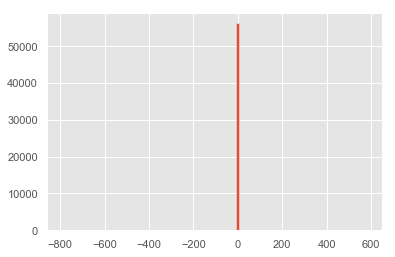

In [22]:
df['eT_mono'].hist(bins=100)

(0, 4)

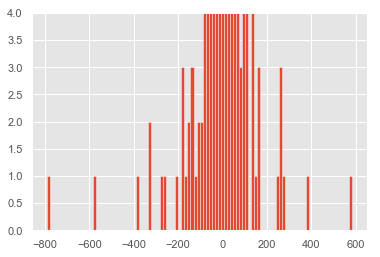

In [23]:
df['eT_mono'].hist(bins=100)
plt.ylim(0,4)

(0, 3)

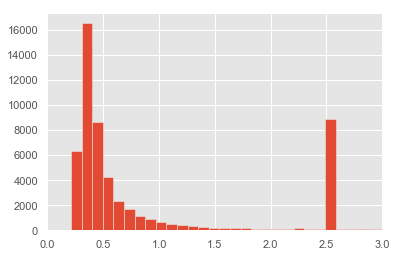

In [24]:
df['wt_mag'].hist(bins=100)
plt.xlim(0,3)

# gm vs gc Plots

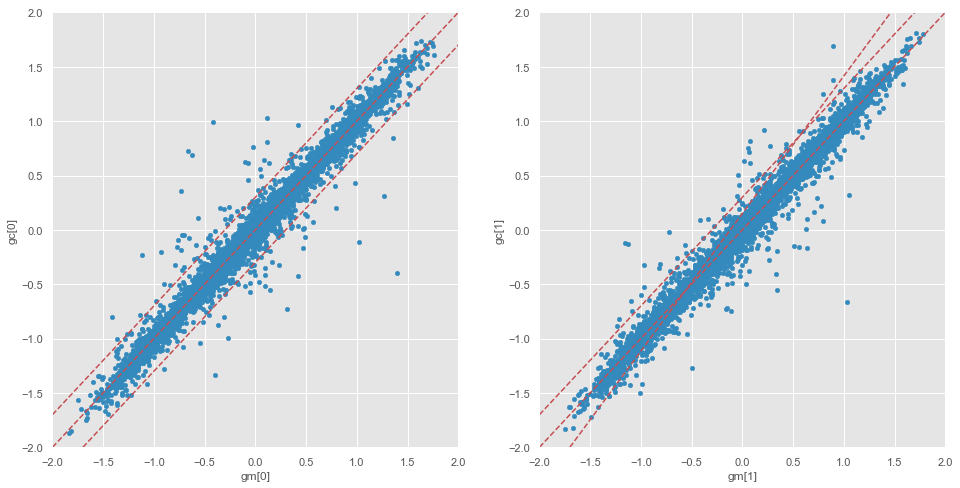

In [26]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
df.plot.scatter(x='gm[0]',y='gc[0]', ax=ax[0])
df.plot.scatter(x='gm[1]',y='gc[1]', ax=ax[1])

ax[0].set_xlim(-2.0,2.0)
ax[0].set_ylim(-2.0,2.0)

ax[1].set_xlim(-2.0,2.0)
ax[1].set_ylim(-2.0,2.0)

# 45 degree line
n=2.0
ax[0].plot([-n,n],[-n,n],'r--')
ax[1].plot([-n,n],[-n,n],'r--')

# -------- left plot -----------
# for slope 1 ==> y2-y1 = x2-x1
#
# upper line
x1 = -2.0 
y1 = -1.7
x2 = 2.0
y2 = y1-x1+x2
ax[0].plot([x1,x2],[y1,y2],'r--')

# lower line
x1 = -1.7
y1 = -2.0
x2 = 2.0
y2 = y1-x1+x2
ax[0].plot([x1,x2],[y1,y2],'r--')

# -------- right plot -----------
# upper line
x1 = -2.0 
y1 = -1.7
x2 = 2.0
y2 = y1-x1+x2
ax[1].plot([x1,x2],[y1,y2],'r--')

# lower line
x1 = -1.7 
y1 = -2.0
x2 = 2.0
x2 = y1-x1+x2
ax[1].plot([x1,x2],[y1,y2],'r--')

In [28]:
df_new = df.copy()

```
Equation of straight line:
y-y1 = y2-y1 * (x-x1)
       -----
       x2-x1

boundary: (x2-x1) * (y-y1) - (y2-y1) * (x-x1)
```

In [29]:
# LEFT UPPER line:  filter from gm0 vs gc0 
x1 = -2.0 
y1 = -1.7 
x2 = 2.0
y2 = y1-x1+x2
cond = ( (x2-x1) * (df_new['gc[0]'] -y1))    >=  ( (y2-y1) * (df_new['gm[0]'] - x1 ) )
df_new['above_gm_gc0'] = cond

# LEFT LOWER line:  filter from gm0 vs gc0 
x1 = -1.7
y1 = -2.0
x2 = 2.0
y2 = y1-x1+x2
cond = ( (x2-x1) * (df_new['gc[0]'] -y1))    <=  ( (y2-y1) * (df_new['gm[0]'] - x1 ) )
df_new['below_gm_gc0'] = cond


# RIGHT UPPER line:  filter from gm1 vs gc1 
x1 = -2.0 
y1 = -1.7
x2 = 2.0
y2 = y1-x1+x2
cond = ( (x2-x1) * (df_new['gc[1]'] -y1))    >=  ( (y2-y1) * (df_new['gm[1]'] - x1 ) )
df_new['above_gm_gc1'] = cond

# RIGHT LOWER line:  filter from gm1 vs gc1 
x1 = -1.7
y1 = -2.0
x2 = 2.0
y2 = y1-x1+x2
cond = ( (x2-x1) * (df_new['gc[1]'] -y1))    <=  ( (y2-y1) * (df_new['gm[1]'] - x1 ) )
df_new['below_gm_gc1'] = cond


In [30]:
df_new.iloc[:2,-5:]

,eT_chro_times_wt,above_gm_gc0,below_gm_gc0,above_gm_gc1,below_gm_gc1
0,0.131281,False,False,False,False
1,-0.045934,False,False,False,False


In [31]:
df_new_middle = df_new.query(""" above_gm_gc0 == False \
                             and below_gm_gc0 == False \
                             and above_gm_gc1 == False \
                             and below_gm_gc1 == False""")

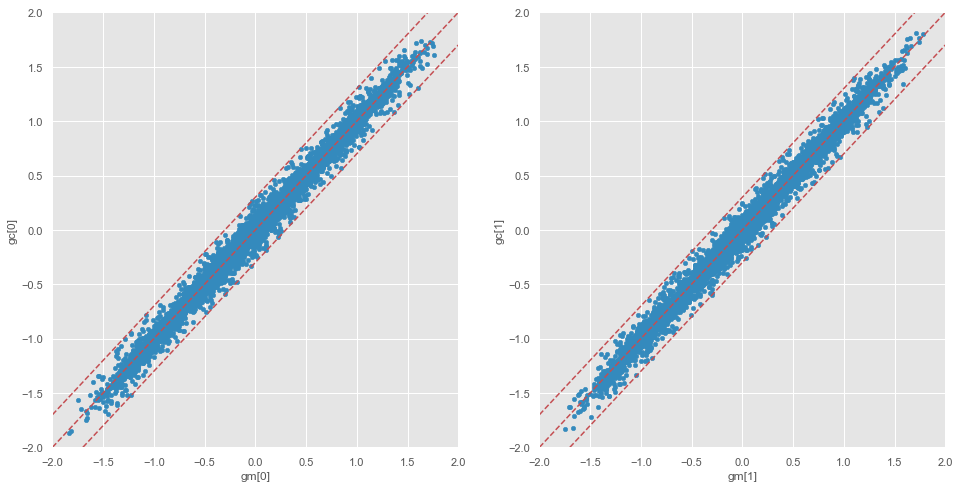

In [32]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

df_new_middle.plot.scatter(x='gm[0]',y='gc[0]', ax=ax[0])
df_new_middle.plot.scatter(x='gm[1]',y='gc[1]', ax=ax[1])

ax[0].set_xlim(-2.0,2.0)
ax[0].set_ylim(-2.0,2.0)

ax[1].set_xlim(-2.0,2.0)
ax[1].set_ylim(-2.0,2.0)

# 45 degree line
n=2.0
ax[0].plot([-n,n],[-n,n],'r--')
ax[1].plot([-n,n],[-n,n],'r--')

# -------- left plot -----------
# for slope 1 ==> y2-y1 = x2-x1
#
# upper line
x1 = -2.0 
y1 = -1.7 # change this only
x2,y2 = 2.0, y1-x1+x2
ax[0].plot([x1,x2],[y1,y2],'r--')

# lower line
x1 = -1.7 # change this only
y1 = -2.0
x2,y2 = 2.0, y1-x1+x2
ax[0].plot([x1,x2],[y1,y2],'r--')

# -------- right plot -----------
# upper line
x1 = -2.0 
y1 = -1.7 # change this only
x2,y2 = 2.0, y1-x1+x2
ax[1].plot([x1,x2],[y1,y2],'r--')

# lower line
x1 = -1.7 # change this only
y1 = -2.0
x2,y2 = 2.0, y1-x1+x2
ax[1].plot([x1,x2],[y1,y2],'r--')